In [40]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns
plt.rcParams.update({'font.size': 16})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get all the data for subjects, agents of interest

In [41]:
def load_subject_data(row, beh_path):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh["session"] = session
    return beh

def load_agent_data(row, beh_path):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh["session"] = session
    return beh

In [42]:
subject_to_data = {}

In [43]:
fig_out_dir = "/data/patrick_res/figures/wcst_paper"

In [44]:
# Monkey S
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = SESS_BEHAVIOR_PATH
sam_res = pd.concat(sessions.apply(lambda x: load_subject_data(x, beh_path), axis=1).values)
sam_res["subject"] = "Monkey S"
subject_to_data["Monkey S"] = sam_res

In [45]:
# Monkey B
# sessions = pd.DataFrame({"session_name": [20190123, 20190124, 20190125, 20190128, 20190312, 20190313, 20190329]})
sessions = pd.read_pickle("/data/patrick_res/sessions/BL/valid_sessions_61.pickle")
beh_path = "/data/rawdata/sub-BL/sess-{sess_name}/behavior/sub-BL_sess-{sess_name}_object_features.csv"
blanche_res = pd.concat(sessions.apply(lambda x: load_subject_data(x, beh_path), axis=1).values)
blanche_res["subject"] = "Monkey B"
subject_to_data["Monkey B"] = blanche_res

In [46]:
AGENT_BEH_DIR = "/data/patrick_res/rl/beh"
agent_to_model_names = {
    "Task RNN": "two_step_block_switching", 
    "Prob 0.75 RNN": "two_step_block_switching_prob0.75", 
    "Matching RNN": "shared_belief_rnn_prob_matches_sam_0_beta_0.75", 
    # "Separate Matching": "separate_belief_rnn_prob_matches_sam_0_beta_0.75",
    "Optimal": "optimal_agent",
    "Feature RL": "fitted_feature_rl",
    "Feature RL w Decay": "fitted_feature_rl_w_decay",
    "Belief State S": "fitted_belief_state_agent",
    "Belief State B": "fitted_belief_state_agent_BL",
}
for i, (agent_name, model_name),  in enumerate(agent_to_model_names.items()):
    session_name = "{sess_name}"
    beh_path = f"/data/patrick_res/rl/beh/{model_name}_session_{session_name}.csv"
    sessions = pd.DataFrame({"session_name": np.arange(10)})
    agent_res = pd.concat(sessions.apply(lambda x: load_agent_data(x, beh_path), axis=1).values)
    agent_res["subject"] = agent_name
    subject_to_data[agent_name] = agent_res

In [83]:
all_data = pd.concat(subject_to_data.values())
# sub_data = all_data[all_data.subject.isin(["Optimal RNN", "Feature RL", "Belief State", "Matching RNN", "Monkey S"])]
# sub_data = all_data[all_data.subject.isin(["Optimal RNN", "Feature RL", "Feature RL w Decay", "Belief State", "Matching RNN", "Monkey S"])]
# agent_list_w_monkey = ["Task RNN", "Feature RL w Decay", "Belief State", "Matching RNN", "Monkey Beh"]
agent_list_w_monkey = ["Belief State S", "Feature RL w Decay", "Monkey S", "Optimal"]
# agent_list_w_monkey = ["Monkey B", "Belief State B"]
# agent_list_w_monkey = ["Monkey B", "Monkey S"]

sub_data = all_data[all_data.subject.isin(agent_list_w_monkey)]


### Plot Prob Correct

[Text(0, 0, '0'), Text(5, 0, '5'), Text(10, 0, '10'), Text(15, 0, '15')]

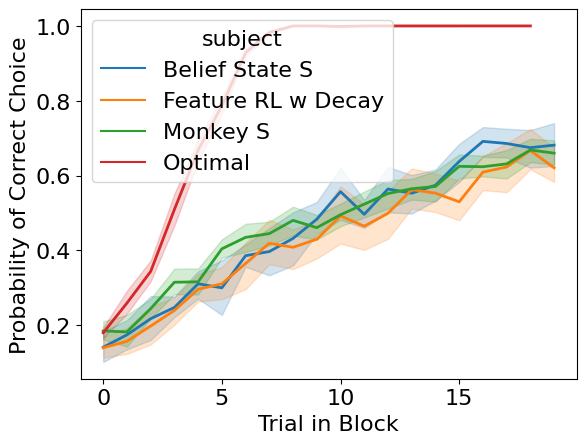

In [84]:

res = sub_data.groupby(["subject", "session"], group_keys=True).apply(lambda group: behavioral_utils.get_prob_correct_by_block_pos(group, 20)).reset_index()
fig, ax = plt.subplots()
sns.lineplot(data=res, x="TrialInBlock", y="ProbCorrect", hue="subject", hue_order=agent_list_w_monkey, ax=ax, linewidth=2)
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[1:], labels=labels[1:])
ax.set_xlabel("Trial in Block")
ax.set_ylabel("Probability of Correct Choice") 
ax.set_xticks([0, 5, 10, 15])
ax.set_xticklabels([0, 5, 10, 15])
# ax.axhline(0.25, color='black', linestyle='dotted', label="Chance")

# fig.savefig(f"{fig_out_dir}/prob_correct_monkey_B_beliefs.png")

### Plot block lengths

In [85]:
def get_block_lengths(beh):
    res = beh.groupby("BlockNumber", group_keys=True).TrialNumber.nunique().reset_index()
    return res.rename(columns={"TrialNumber": "Average Block Length"})

block_res = sub_data.groupby(["subject", "session"], group_keys=True).apply(get_block_lengths).reset_index()


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 76.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0, 'Belief State S'),
 Text(1, 0, 'Feature RL w Decay'),
 Text(2, 0, 'Monkey S'),
 Text(3, 0, 'Optimal')]

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


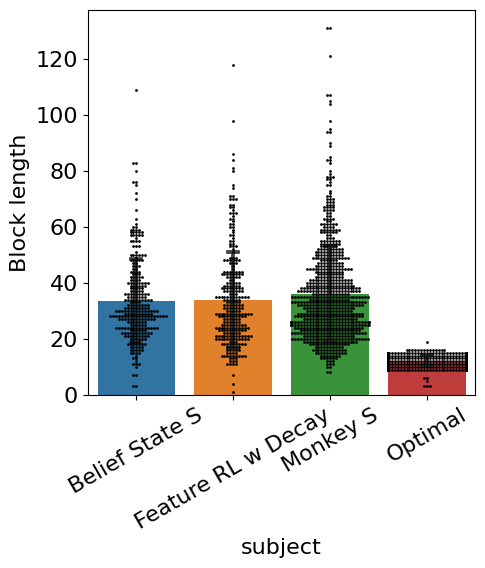

In [86]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(data=block_res, x="subject", y="Average Block Length", errorbar='sd', capsize=.1, order=agent_list_w_monkey, ax=ax)
sns.swarmplot(data=block_res, x="subject", y="Average Block Length", color="0", size=2, order=agent_list_w_monkey, alpha=1, ax=ax)

# ax.set_xticklabels(subject_names)
ax.set_ylabel("Block length")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

# fig.savefig(f"{fig_out_dir}/block_lengths_monkey_B_beliefs.png")

### Plot Average Reward Rates

In [87]:
def avg_reward_rate(beh):
    return pd.Series({"Reward Rate": len(beh[beh.Response == "Correct"]) / len(beh)})
reward_res = sub_data.groupby(["subject", "session"], group_keys=True).apply(avg_reward_rate).reset_index()


[Text(0, 0, 'Belief State S'),
 Text(1, 0, 'Feature RL w Decay'),
 Text(2, 0, 'Monkey S'),
 Text(3, 0, 'Optimal')]

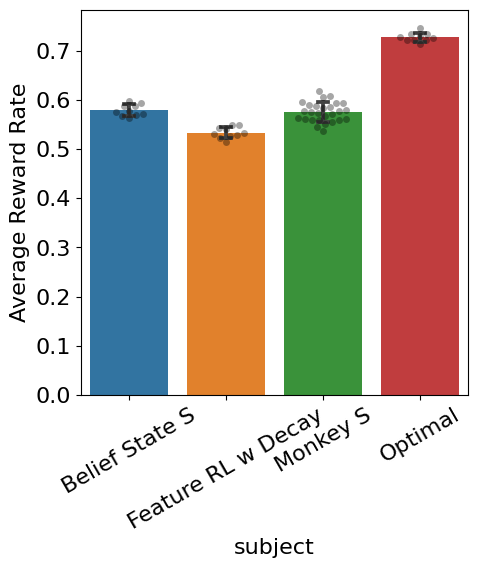

In [88]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(data=reward_res, x="subject", y="Reward Rate", capsize=.1, errorbar='sd', order=agent_list_w_monkey, ax=ax)
sns.swarmplot(data=reward_res, x="subject", y="Reward Rate", order=agent_list_w_monkey, color="0", alpha=.35, ax=ax)

# ax.set_xticklabels(subject_names)
ax.set_ylabel("Average Reward Rate")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

# fig.savefig(f"{fig_out_dir}/reward_rates_monkey_B_beliefs.png")

### Plot Perseveration Probabilities

[<matplotlib.lines.Line2D object at 0x7fa648ba35b0>, <matplotlib.lines.Line2D object at 0x7fa648ba3be0>, <matplotlib.lines.Line2D object at 0x7fa648b3f5b0>, <matplotlib.lines.Line2D object at 0x7fa648b3c550>]
['Belief State S', 'Feature RL w Decay', 'Monkey S', 'Optimal']


[Text(0, 0, '0'), Text(5, 0, '5'), Text(10, 0, '10')]

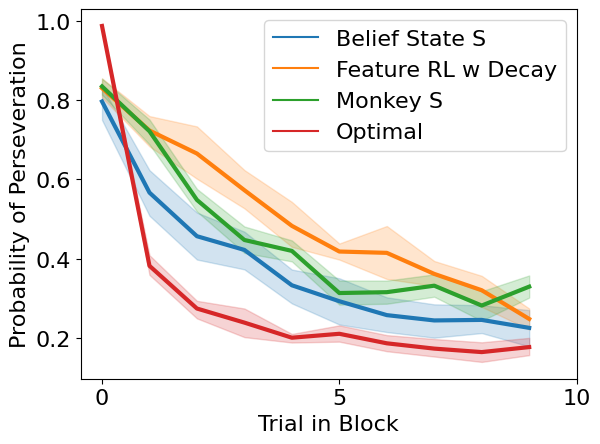

In [89]:
pers_res = sub_data.groupby(["subject", "session"], group_keys=True).apply(lambda group: behavioral_utils.get_prob_perseveration_by_block_pos(group, 10)).reset_index()
fig, ax = plt.subplots()
sns.lineplot(data=pers_res, x="TrialInBlock", y="Prob Perseverate", hue="subject", hue_order=agent_list_w_monkey, linewidth=3, ax=ax)
handles, labels = ax.get_legend_handles_labels()
print(handles)
print(labels)
ax.legend(handles=handles, labels=labels)
ax.set_xlabel("Trial in Block")
ax.set_ylabel("Probability of Perseveration") 
ax.set_xticks([0, 5, 10])
ax.set_xticklabels([0, 5, 10])
# ax.axhline(0.25, color='black', linestyle='dotted', label="Chance")

# fig.savefig(f"{fig_out_dir}/perseverations_monkey_B_beliefs.png")


### Negative log likelihood of agents
with data from notebooks/wcst/20240930_compute_beh_nll_for_rnns.ipynb 

In [90]:
# all_nll_res = pd.read_pickle("/data/patrick_res/behavior/models/agent_fits_w_rnns.pickle")
all_nll_res = pd.read_pickle("/data/patrick_res/behavior/models/agent_fits.pickle")

# agent_list = ["Task RNN", "Feature RL w Decay", "Belief State", "Matching RNN"]
# agent_list = ["Optimal", "Feature RL w Decay", "Belief State"]
agent_list = ["Belief State", "Feature RL w Decay"]

sub_nll_res = all_nll_res[all_nll_res.agent.isin(agent_list)]

In [91]:
sub_nll_res

,agent,mean_nll2,accuracy
0,Belief State,1.297482,0.664414
2,Feature RL w Decay,1.244054,0.672297
4,Belief State,1.446681,0.610487
6,Feature RL w Decay,1.348124,0.634831
8,Belief State,1.382591,0.653179
...,...,...,...
170,Feature RL w Decay,1.390927,0.635645
172,Belief State,1.374082,0.645570
174,Feature RL w Decay,1.298268,0.663096
176,Belief State,1.444384,0.613054


Text(0, 0.5, 'Average NLL of monkey card choice')

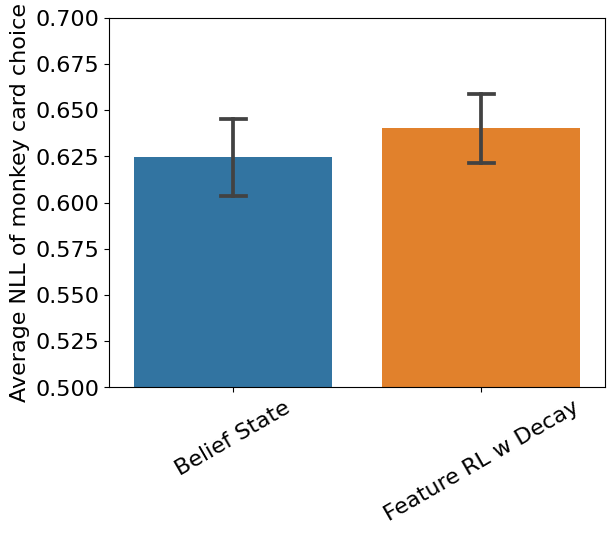

In [92]:
fig, ax = plt.subplots()
# sns.barplot(sub_nll_res, x="agent", y="mean_nll2", order=agent_list, capsize=.1, errorbar="sd", ax=ax)
sns.barplot(sub_nll_res, x="agent", y="accuracy", order=agent_list, capsize=.1, errorbar="sd", ax=ax)

# sns.swarmplot(data=sub_res, x="agent", y="mean_nll2", order=agent_list, color="0", alpha=.35, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel("")
ax.set_ylim([0.5, 0.7])
ax.set_ylabel("Average NLL of monkey card choice")

# fig.savefig(f"{fig_out_dir}/nll_beliefs.png")

### 2025 Cosyne Figure 1: Likelihood and Perseveration, Avg reward, Block Length

[<matplotlib.lines.Line2D object at 0x7fa5d3c6f3d0>, <matplotlib.lines.Line2D object at 0x7fa5d3c6fca0>, <matplotlib.lines.Line2D object at 0x7fa5d3c6fd90>, <matplotlib.lines.Line2D object at 0x7fa5d3c6f670>]
['Belief State S', 'Feature RL w Decay', 'Monkey S', 'Optimal']


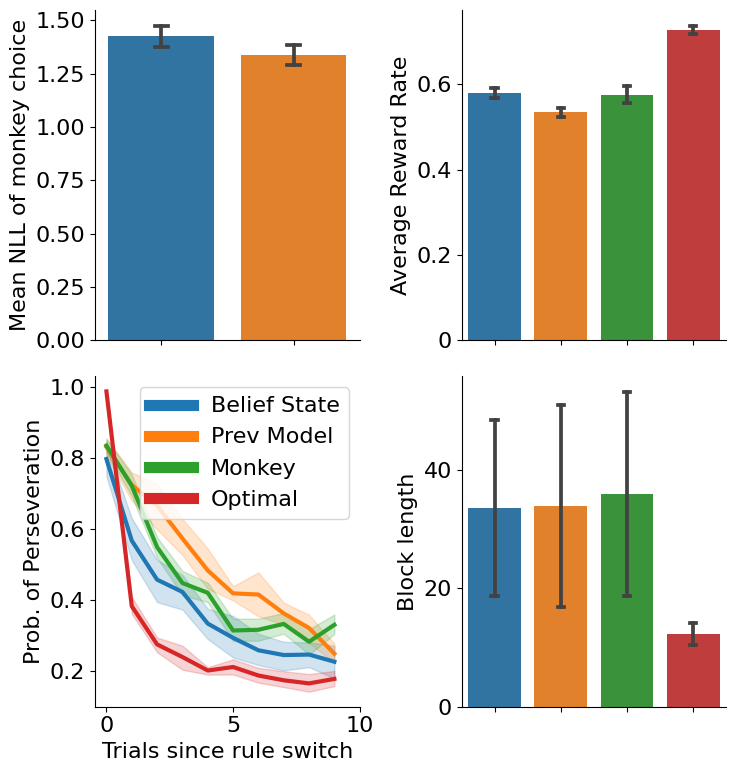

In [114]:
fig, axs = plt.subplots(2, 2, figsize=(7.5, 8))
ax = axs[0, 0]
sns.barplot(sub_nll_res, x="agent", y="mean_nll2", order=agent_list, capsize=.1, errorbar="sd", ax=ax)
ax.set_xticklabels("")
ax.set_xlabel("")
ax.set_ylabel("Mean NLL of monkey choice")
ax.spines[['right', 'top']].set_visible(False)

ax = axs[0, 1]
sns.barplot(data=reward_res, x="subject", y="Reward Rate", capsize=.1, errorbar='sd', order=agent_list_w_monkey, ax=ax)
ax.set_ylabel("Average Reward Rate")
ax.set_xticklabels("")
ax.set_xlabel("")
ax.set_yticks([0, 0.2, 0.4, 0.6])
ax.set_yticklabels([0, 0.2, 0.4, 0.6])
ax.spines[['right', 'top']].set_visible(False)


ax = axs[1, 0]
sns.lineplot(data=pers_res, x="TrialInBlock", y="Prob Perseverate", hue="subject", hue_order=agent_list_w_monkey, linewidth=3, ax=ax)

handles, labels = ax.get_legend_handles_labels()
print(handles)
print(labels)
# ax.legend(handles=handles, labels=["Belief State", "Prev Model", "Monkey", "Optimal"])
# ax.get_legend().remove()
ax.legend(handles=handles, labels=["Belief State", "Prev Model", "Monkey", "Optimal"])

for line in ax.get_legend().get_lines():
    line.set_linewidth(8)

ax.set_xlabel("Trials since rule switch")
ax.set_ylabel("Prob. of Perseveration") 
ax.set_xticks([0, 5, 10])
ax.set_xticklabels([0, 5, 10])
ax.spines[['right', 'top']].set_visible(False)

ax = axs[1, 1]
sns.barplot(data=block_res, x="subject", y="Average Block Length", capsize=.1, errorbar='sd', order=agent_list_w_monkey, ax=ax)
# sns.swarmplot(data=reses, color="0", alpha=.35, ax=ax)

# ax.set_xticklabels(subject_names)
ax.set_ylabel("Block length")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xticklabels("")
ax.set_yticks([0, 20, 40])
ax.set_yticklabels([0, 20, 40])
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)



fig.tight_layout()
# fig.savefig("/data/patrick_res/figures/2025_cosyne_abstract/beh_combined.svg")
fig.savefig("/data/patrick_res/figures/2025_fadex_poster/beh_combined.svg")